In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
import hashlib
from sklearn.utils import shuffle
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Caminho para os diretórios de treino e teste
train_dir = 'C:\\Users\\VascoC\\Desktop\\TumoresDS\\Training'
test_dir = 'C:\\Users\\VascoC\\Desktop\\TumoresDS\\Testing'


labels = ['glioma', 'notumor', 'meningioma', 'pituitary']

# Hyperparameters
batch_size = 32
epochs = 15
image_size = 150

In [5]:
# Encontrar e eliminar duplicates
def compute_hash(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hash_object = hashlib.md5(img)
    return hash_object.hexdigest()

def find_and_delete_duplicates(directory):
    hashes = {}
    duplicates = []
    for label in labels:
        folder_path = os.path.join(directory, label)
        for file in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
            file_path = os.path.join(folder_path, file)
            file_hash = compute_hash(file_path)
            if file_hash in hashes:
                duplicates.append(file_path)
                os.remove(file_path)
            else:
                hashes[file_hash] = file_path
    return duplicates

train_duplicates = find_and_delete_duplicates(train_dir)
test_duplicates = find_and_delete_duplicates(test_dir)

print(f"Eliminados {len(train_duplicates)} duplicates do training set.")
print(f"Eliminados {len(test_duplicates)} duplicates do testing set.")

Processing pituitary: 100%|██████████| 300/300 [00:01<00:00, 214.30it/s]

Eliminados 207 duplicates do training set.
Eliminados 30 duplicates do testing set.


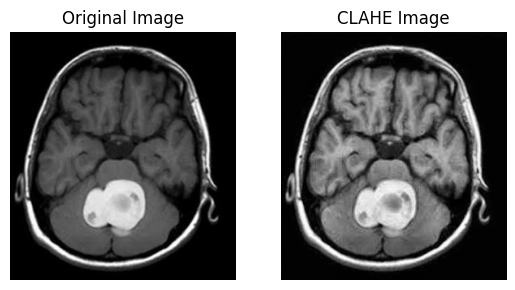

In [6]:
# PIXEL TRANSFORMATION
image_path = "C:\\Users\\VascoC\\Desktop\\TumoresDS\\Testing\\meningioma\\Te-me_0029.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Aplicar CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(image)
    
# Imagem Original / Imagem CLAHE
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off') 

plt.subplot(1, 2, 2)
plt.imshow(clahe_image, cmap='gray')
plt.title('CLAHE Image')
plt.axis('off')

plt.show()


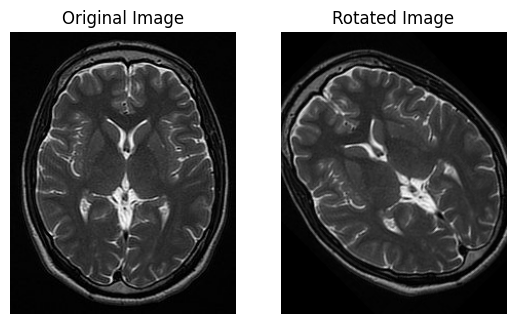

In [7]:
#Geometric Operation

image_path = "C:\\Users\\VascoC\\Desktop\\TumoresDS\\Testing\\notumor\\Te-no_0080.jpg"
image = cv2.imread(image_path)

angle = 45
height, width = image.shape[:2]
rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))


plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off') 

plt.subplot(1, 2, 2)
plt.imshow(rotated_image, cmap='gray')
plt.title('Rotated Image')
plt.axis('off') 

plt.show()

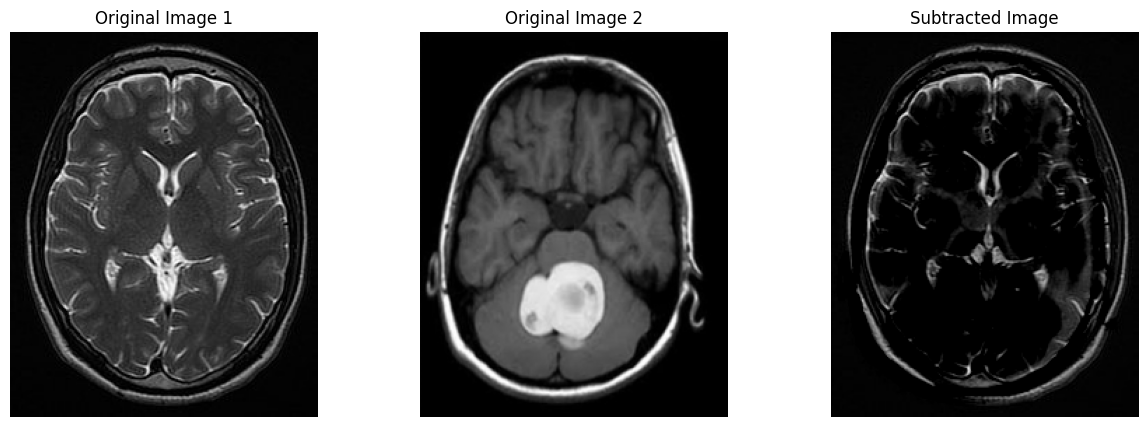

In [8]:
# Arithmetic Operation

image_path1 = 'C:\\Users\\VascoC\\Desktop\\TumoresDS\\Testing\\notumor\\Te-no_0080.jpg'  
image_path2 = 'C:\\Users\\VascoC\\Desktop\\TumoresDS\\Testing\\meningioma\\Te-me_0029.jpg'  
image1 = cv2.imread(image_path1) 
image2 = cv2.imread(image_path2) 

image2_resized = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

# Subtrair as duas imagens
subtracted_image = cv2.subtract(image1, image2_resized)

image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2_resized, cv2.COLOR_BGR2RGB)
subtracted_image_rgb = cv2.cvtColor(subtracted_image, cv2.COLOR_BGR2RGB)

# Imagens
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image1_rgb)
plt.title('Original Image 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image2_rgb)
plt.title('Original Image 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(subtracted_image_rgb)
plt.title('Subtracted Image')
plt.axis('off')

plt.show()

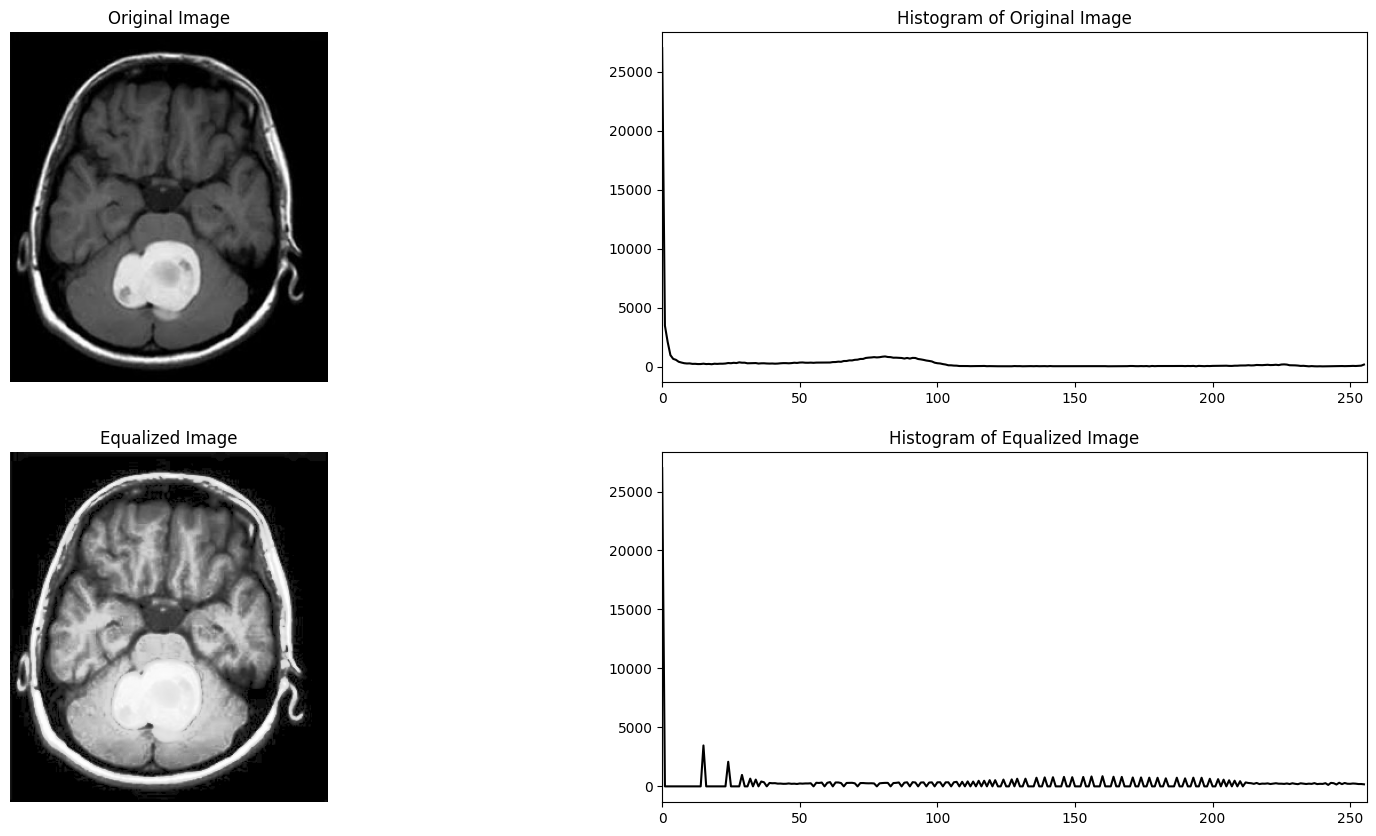

In [10]:
# Histogram e analise
image_path = 'C:\\Users\\VascoC\\Desktop\\TumoresDS\\Testing\\meningioma\\Te-me_0029.jpg'
image = cv2.imread(image_path)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Histograma
hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])

# Equalização do histograma
equalized_image = cv2.equalizeHist(gray_image)

equalized_hist = cv2.calcHist([equalized_image], [0], None, [256], [0, 256])

plt.figure(figsize=(20, 10))

# Imagem original
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Histograma da imagem original
plt.subplot(2, 2, 2)
plt.plot(hist, color='black')
plt.title('Histogram of Original Image')
plt.xlim([0, 256])

# Imagem equalizada
plt.subplot(2, 2, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

# Histograma da imagem equalizada
plt.subplot(2, 2, 4)
plt.plot(equalized_hist, color='black')
plt.title('Histogram of Equalized Image')
plt.xlim([0, 256])

plt.show()


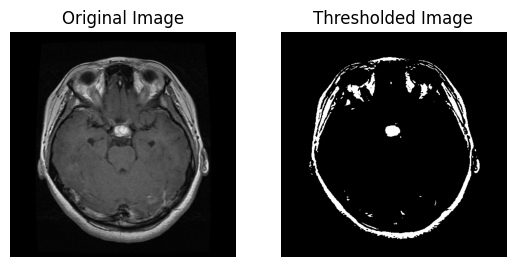

In [11]:
# Segmentation Techniques
image_path = 'C:\\Users\\VascoC\\Desktop\\TumoresDS\\Testing\\pituitary\\Te-pi_0035.jpg'
image = cv2.imread(image_path)  

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Thresholding
_, thresh_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(thresh_image, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

plt.show()


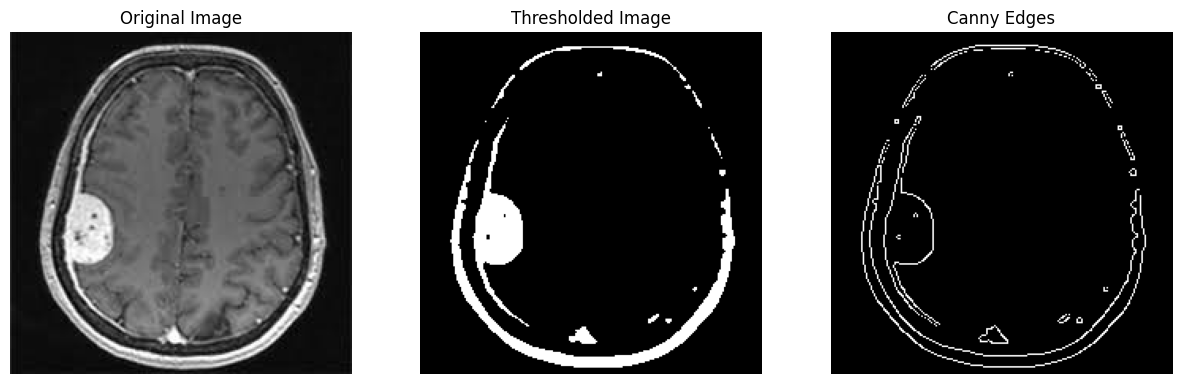

In [12]:
image_path = "C:\\Users\\VascoC\\Desktop\\TumoresDS\\Testing\\meningioma\\Te-me_0062.jpg"
image = cv2.imread(image_path)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Gaussian Blur
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Threshold
_, thresh_image = cv2.threshold(blurred_image, 140, 255, cv2.THRESH_BINARY)

# Canny
edges = cv2.Canny(thresh_image, 30, 100) 

# Aumentar tamanho das figuras
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(thresh_image, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')

plt.show()


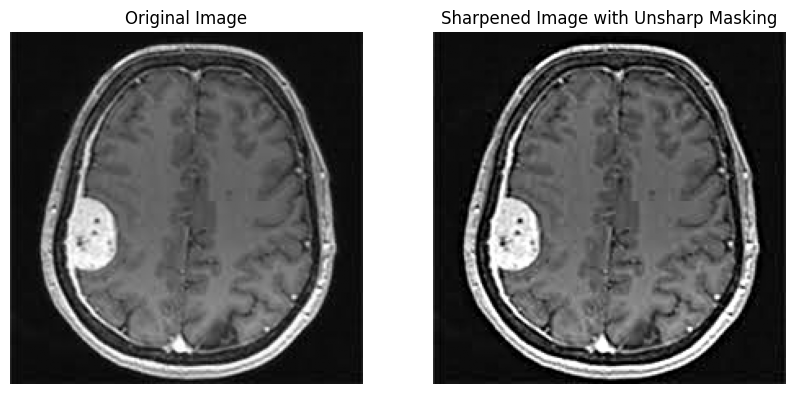

In [13]:
image_path = "C:\\Users\\VascoC\\Desktop\\TumoresDS\\Testing\\meningioma\\Te-me_0062.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  

# Gaussian Blur
blurred = cv2.GaussianBlur(image, (9, 9), 10.0)

sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sharpened, cmap='gray')
plt.title('Sharpened Image with Unsharp Masking')
plt.axis('off')

plt.show()



In [14]:
# Carregar imagens

X_train = []
y_train = []
X_train = []
y_train = []
image_size = image_size
for i in labels:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 300/300 [00:00<00:00, 1404.39it/s]


In [15]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

X_train.shape

X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=101)

y_train_ds = []
for i in y_train:
    y_train_ds.append(labels.index(i))
y_train = y_train_ds
y_train = tf.keras.utils.to_categorical(y_train)


y_test_ds = []
for i in y_test:
    y_test_ds.append(labels.index(i))
y_test = y_test_ds
y_test = tf.keras.utils.to_categorical(y_test)

In [16]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [17]:
# Construção do modelo
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [18]:
# Callbacks
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_delta=0.001, mode='auto', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [27]:
# Treinamento do modelo
history = model.fit(X_train,y_train,validation_split=0.1, epochs =epochs, verbose=1, batch_size=batch_size,
                   callbacks=[tensorboard,checkpoint,reduce_lr, early_stopping])

Epoch 1/15
 33/163 ━━━━━━━━━━━━━━━━━━━━ 2:22 1s/step - accuracy: 0.9408 - loss: 0.1895

KeyboardInterrupt: 

In [20]:
# Avaliação do modelo
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

print(classification_report(y_test_new, pred))


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       278
           1       0.98      0.95      0.97       236
           2       0.95      0.76      0.84       263
           3       0.70      1.00      0.82       241

    accuracy                           0.87      1018
   macro avg       0.89      0.87      0.87      1018
weighted avg       0.89      0.87      0.87      1018



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


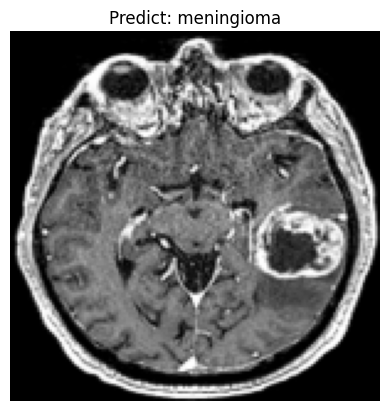

In [25]:
# Predict Imagens
def load_image(image_path, image_size=150):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, (image_size, image_size))
        img_expanded = np.expand_dims(img, axis=0) 
    return img, img_expanded

image_path = 'C:\\Users\\VascoC\\Desktop\\image1-30.jpeg'

image, image_for_prediction = load_image(image_path)

# Fazer predict na imagem
prediction = model.predict(image_for_prediction)
prediction = np.argmax(prediction, axis=1)[0]  # Pega a predição mais provável

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Predict: {labels[prediction]}")
plt.axis('off') 
plt.show()